# **Learning to Protect Communications with Adversarial Neural Cryptography**

Abadi, M., & Andersen, D. G. (2016). Learning to protect communications with adversarial neural cryptography. arXiv preprint arXiv:1610.06918.

## **Abstract**

We tried to implement the contents of the thesis as much as possible, but some modifications were added to the contents that were omitted or thought to need improvement.

* Iteration: In the thesis, 25000 steps of mini-batch training was performed in one training, but in reality only 3000 steps were repeated.

* Key Generation: Information on whether to remove a new key each time or keep the key that was first pulled is missing. Therefore, like Plaintext, Private (Shared) Key was created differently each time using Pseudo Random Number Generator.

* Loss Function for Alice & Bob: Added 1 to loss(P)-loss(P_Bob) described in the paper. The old method thought that Alice & Bob's losses were a bit unnatural because they existed in the interval \[-1, 0 + epsilon\).

* GradientTape: To calculate Bob's loss, Eve's loss is needed, which in turn needs Alice's output (Ciphertext). However, since Alice and Bob are connected, there is an unnatural feeling that must precede each other. So, we opened Alice & Bob's and Eve's GradientTape at the same time, training and calculating losses at once.

All experimental contine aftedcommitting to Tensorboard Dev, and you can also check them at the address below:

*https://tensorboard.dev/experiment/AhGDXCQ3QlmTkxLNCofqpQ/*

## **Default Setting**

In [108]:
import tensorflow as tf

import datetime

from pathlib import Path

print(f"tf.__version__: {tf.__version__}")

tf.__version__: 2.4.1


In [2]:
class HParams(object):
    def __init__(self):
        self.N = 16 ## 16 bits
        self.global_batch_sz = 4096
        self.auto = tf.data.AUTOTUNE
        
HPARAMS = HParams()

## **Dataset Pipeline**

In [148]:
prng = tf.random.Generator.from_non_deterministic_state()

# @tf.function
def generator():
    while True:
        ## Generate random bits with a batched shape. 
        ## This may reduces repetitive prng calls.
        uniformed_bits = prng.uniform((HPARAMS.global_batch_sz, HPARAMS.N), 
                                      minval = -1, maxval = 1, dtype = tf.float32)
        
        ## The range of the uniform function is the semi-opening of [-1, 1). 
        ## Therefore, we cast the section by dividing it into [-1, 0), [0, 1).
        yield tf.where(uniformed_bits >= 0, 1., -1)

In [149]:
## The key is selected anew each time. This part was not mentioned 
## in the paper, but of course I decided that it would be reasonable 
## to use a new key every time.
bit_gen = tf.data.Dataset.from_generator(
    generator, 
    output_signature = tf.TensorSpec(shape = (HPARAMS.global_batch_sz, HPARAMS.N), dtype = tf.float32))

key_gen = tf.data.Dataset.from_generator(
    generator, 
    output_signature = tf.TensorSpec(shape = (HPARAMS.global_batch_sz, HPARAMS.N), dtype = tf.float32))

ds = tf.data.Dataset.zip((bit_gen, key_gen)
            ).repeat(
            ).prefetch(HPARAMS.auto)

In [76]:
for element in ds.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(4096, 16) (4096, 16)


In [77]:
foo

<tf.Tensor: shape=(4096, 16), dtype=float32, numpy=
array([[-1., -1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ...,  1., -1., -1.],
       ...,
       [ 1., -1., -1., ..., -1., -1.,  1.],
       [-1.,  1., -1., ...,  1., -1.,  1.],
       [ 1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>

In [78]:
bar

<tf.Tensor: shape=(4096, 16), dtype=float32, numpy=
array([[-1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       [-1.,  1.,  1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1.,  1.]], dtype=float32)>

## **Build the Network**

In [5]:
def Communicator(model_name, N = HPARAMS.N):

    def Node(model_name):
        x_1 = model_input_1 = tf.keras.layers.Input(shape = (N,))
        x_2 = model_input_2 = tf.keras.layers.Input(shape = (N,))

        ## Concat two texts.
        x = tf.keras.layers.Concatenate()([x_1, x_2])

        ## A fully connected layer.
        x = tf.keras.layers.Dense(2 * N)(x)

        ## Four 1-D convolutional layers followed by a sigmoid activation function.
        x = tf.keras.layers.Reshape((-1, 1))(x) ## expand dims
        
        for i, (filters, kernel_size, strides) in enumerate([(4, 2, 1), (2, 4, 2), (1, 4, 1), (1, 1, 1)]):
            x = tf.keras.layers.Conv1D(filters = filters, 
                                    kernel_size = kernel_size, 
                                    strides = strides,
                                    padding = "same")(x)
            ## Apply sigmoid without the final layer.
            if i != 3:
                x = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(x)

        ## Apply tanh nonlinear unit.
        x = tf.keras.layers.Reshape((-1,))(x)
        model_output = x = tf.keras.layers.Activation(tf.keras.activations.tanh)(x)

        return tf.keras.Model(
            inputs = [model_input_1, model_input_2],
            outputs = model_output,
            name = model_name)

    P = model_input_1 = tf.keras.layers.Input(shape = (N,)) ## Plaintext
    K = model_input_2 = tf.keras.layers.Input(shape = (N,)) ## Shared key

    Alice = Node("Alice")
    Bob   = Node("Bob")
    
    ## Bob, like Alice, takes a key bit as the second argument.
    C = Alice([P, K])
    P_Bob = Bob([C, K])

    return tf.keras.Model(
        inputs = [model_input_1, model_input_2],
        outputs = [C, P_Bob],
        name = model_name)
    
        
def Eavesdropper(model_name, N = HPARAMS.N):
    x = model_input = tf.keras.layers.Input(shape = (N,))

    ## A fully connected layer.
    x = tf.keras.layers.Dense(2 * N)(x)

    ## Four 1-D convolutional layers followed by a sigmoid activation function.
    x = tf.keras.layers.Reshape((-1, 1))(x) ## expand dims
    
    for i, (filters, kernel_size, strides) in enumerate([(4, 2, 1), (2, 4, 2), (1, 4, 1), (1, 1, 1)]):
        x = tf.keras.layers.Conv1D(filters = filters, 
                                   kernel_size = kernel_size, 
                                   strides = strides,
                                   padding = "same")(x)
        ## Apply sigmoid without the final layer.
        if i != 3:
            x = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(x)

    ## Apply tanh nonlinear unit.
    x = tf.keras.layers.Reshape((-1,))(x)
    model_output = x = tf.keras.layers.Activation(tf.keras.activations.tanh)(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [18]:
tmp = Communicator("Alice_and_Bob")
tmp.summary()

Model: "Alice_and_Bob"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
Alice (Functional)              (None, 16)           1113        input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
Bob (Functional)                (None, 16)           1113        Alice[0][0]          

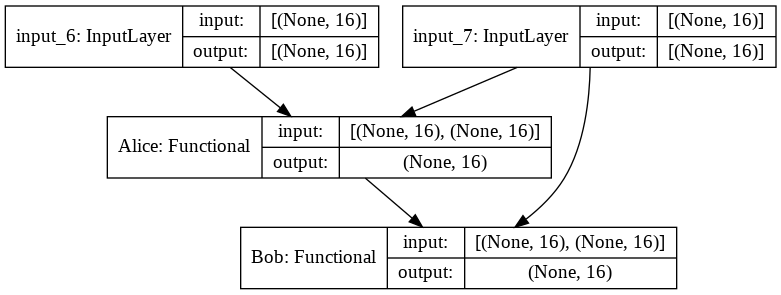

In [19]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [20]:
del tmp

## **Loss Function**

In [132]:
@tf.function
def l1_loss_fn(y_true, y_pred, N = HPARAMS.N):
    l1_error = tf.math.reduce_mean(tf.norm(tf.math.abs(y_true - y_pred), ord = 1, axis = -1))
    bits_wrong = tf.math.abs(N / 2 - l1_error)
    return bits_wrong ** 2 / (N / 2) ** 2, bits_wrong

## **Fit the Networks**

In [150]:
!rm -rf logs

In [151]:
## Generator
Alice_and_Bob = Communicator("Alice_and_Bob")

## Discriminator
Eve   = Eavesdropper("Eve")

In [152]:
## Optimizers
Alice_and_Bob_optimizer = tf.keras.optimizers.Adam(lr = 8e-4)
Eve_optimizer           = tf.keras.optimizers.Adam(lr = 8e-4)

## Loss function
loss_fn = l1_loss_fn

In [153]:
## Tensorboard writer.
nowtime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = Path("logs") / Path("fit") / Path(nowtime)

Alice_and_Bob_summary_writer = tf.summary.create_file_writer(str(log_dir / Path("Alice_and_Bob")))
Eve_summary_writer           = tf.summary.create_file_writer(str(log_dir / Path("Eve")))

In [154]:
# @tf.function
def train_step(P, K, step, N = HPARAMS.N):
    """
        P: Plaintext
        K: Shared secret key
    """

    ## To calculate Alice and Bob's loss, Eve's loss must be calculated first, 
    ## but to calculate Eve's loss, Alice's work must be preceded again. So, 
    ## we create two GradientTapes at the same time and write them all together.
    with tf.GradientTape() as com_tape, tf.GradientTape() as evs_tape:
        C, P_Bob = Alice_and_Bob([P, K], training = True)
        P_Eve = Eve(C, training = True)

        ## Define two losses: communicator's and eavesdropper's.
        ## Alice and Bob's loss naturally moves over the interval 
        ## [0, 2] while learning proceeds in the direction of 
        ## maximizing Eve's loss.
        evs_loss, evs_bit_loss = loss_fn(P, P_Eve)
        com_loss, com_bit_loss = loss_fn(P, P_Bob)
        com_loss = com_loss - evs_loss + 1. 

    ## I wonder if the two models should be combined into one generator.
    gradients_of_Alice_and_Bob = com_tape.gradient(com_loss, Alice_and_Bob.trainable_variables)
    gradients_of_Eve           = evs_tape.gradient(evs_loss, Eve.trainable_variables)

    Alice_and_Bob_optimizer.apply_gradients(zip(gradients_of_Alice_and_Bob, Alice_and_Bob.trainable_variables))
    Eve_optimizer.apply_gradients(zip(gradients_of_Eve, Eve.trainable_variables))
    
    ## Record the loss graph.
    ## Apart from the loss, bits wrong belonging to the 
    ## interval [0, 8] are calculated and recorded.
    with Alice_and_Bob_summary_writer.as_default(step = step):
        tf.summary.scalar("Loss", com_loss)
        tf.summary.scalar("Bits wrong", com_bit_loss)

    with Eve_summary_writer.as_default(step = step):
        tf.summary.scalar("Loss", evs_loss)
        tf.summary.scalar("Bits wrong", evs_bit_loss)

    return com_loss, evs_loss

In [155]:
def train(ds, steps = 3_000):
    for step, (P, K) in enumerate(ds):
        com_loss, evs_loss = train_step(P, K, step)

        ## Display training times of each 10 iters.
        if not (step % 100):
            print(f"[{step:04d}] Alice_and_Bob_loss: {com_loss:.4f}, Eve_loss: {evs_loss:.4f}")

        if step >= steps:
            break

In [156]:
%%time
train(ds)

[0000] Alice_and_Bob_loss: 0.9689, Eve_loss: 1.0159
[0100] Alice_and_Bob_loss: 1.0025, Eve_loss: 0.9990
[0200] Alice_and_Bob_loss: 0.9965, Eve_loss: 1.0014
[0300] Alice_and_Bob_loss: 0.9733, Eve_loss: 1.0057
[0400] Alice_and_Bob_loss: 0.8354, Eve_loss: 0.9855
[0500] Alice_and_Bob_loss: 0.6777, Eve_loss: 0.8792
[0600] Alice_and_Bob_loss: 0.8154, Eve_loss: 0.6459
[0700] Alice_and_Bob_loss: 0.7377, Eve_loss: 0.6953
[0800] Alice_and_Bob_loss: 0.6015, Eve_loss: 0.7393
[0900] Alice_and_Bob_loss: 0.5283, Eve_loss: 0.7484
[1000] Alice_and_Bob_loss: 0.4534, Eve_loss: 0.7611
[1100] Alice_and_Bob_loss: 0.3915, Eve_loss: 0.7789
[1200] Alice_and_Bob_loss: 0.3503, Eve_loss: 0.7935
[1300] Alice_and_Bob_loss: 0.3267, Eve_loss: 0.7934
[1400] Alice_and_Bob_loss: 0.2660, Eve_loss: 0.8375
[1500] Alice_and_Bob_loss: 0.2659, Eve_loss: 0.8216
[1600] Alice_and_Bob_loss: 0.2442, Eve_loss: 0.8282
[1700] Alice_and_Bob_loss: 0.2061, Eve_loss: 0.8529
[1800] Alice_and_Bob_loss: 0.1931, Eve_loss: 0.8548
[1900] Alice

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [ ]:
!tensorboard dev upload --logdir ./logs \
    --name "Experiment of 'Learning to Protect Communications with Adversarial Neural Cryptography'" \
    --description "Implemented training results from the paper 'https://arxiv.org/abs/1610.06918'" \
    --one_shot

In [ ]:
from IPython import display
display.IFrame(
    src = "https://tensorboard.dev/experiment/AhGDXCQ3QlmTkxLNCofqpQ/",
    width = "100%",
    height = "1000px")